# Coin Flips: Random Generation from Bernoulli Distribution

When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ``It looks very suspicious to me," said Barry Blight, a statistics lecturer at the London School of Economics.

- Let's simulate the coin flip experiments.
- Let's try to find an estimate of the probability of head.

In [1]:
import sys
sys.version

'3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]'

In [2]:
import torch
import torch as th
import pyro
import pyro.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

Most distributions in `Pyro` are thin wrappers around `PyTorch` distributions. For details on the PyTorch distribution interface, see `torch.distributions.distribution.Distribution`. For differences between the Pyro and PyTorch interfaces, see `TorchDistributionMixin`.

http://docs.pyro.ai/en/stable/distributions.html

## Simulation with pyro

In [3]:
p = 0.5

In [4]:
udist = pyro.distributions.Uniform(low=0.0, high=1.0)  # generate from uniform distribution U[0,1]
u = udist.sample()     # returned is a torch tensor
X = 1 if u <= p else 0

print(X, u, u.item())   # item() gives python number

1 tensor(0.4322) 0.43223482370376587


In [5]:
udist.sample(sample_shape=torch.Size([3]))  # multiple samples

tensor([0.4069, 0.8659, 0.0826])

In [6]:
# using pyro.sample() function
with pyro.plate('plate', size=5):
    s = pyro.sample('u', pyro.distributions.Uniform(0, 1))
print(s)

tensor([0.0050, 0.2216, 0.7743, 0.3632, 0.3501])


tensor([0., 1.]) torch.float32
tensor([0., 1.]) tensor([0.5000, 0.5000])


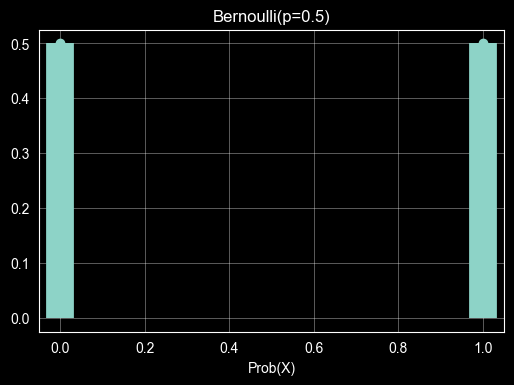

In [7]:
x = torch.tensor([0,1], dtype=torch.float); print(x, x.dtype)
bern_logpmf = pyro.distributions.Bernoulli(probs=p).log_prob(x)  # log probability at x
P = torch.exp(bern_logpmf)
print(x, P)
# plot
markers, stems, base = plt.stem(x.numpy(), P.numpy()); 
stems.set_linewidth(20); base.set_linewidth(0)
plt.title(f'Bernoulli(p={p})'); plt.xlabel('Prob(X)');

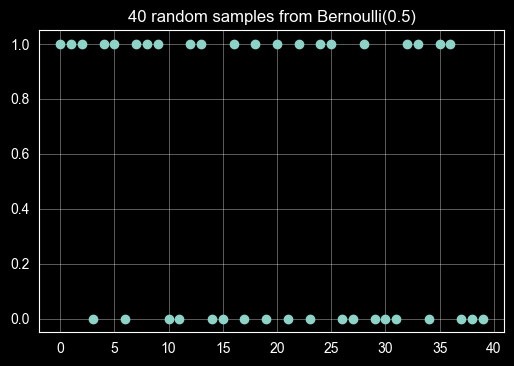

In [8]:
# draw random samples from Bernoulli
X = pyro.distributions.Bernoulli(probs=p).sample(torch.Size([40])); X
plt.plot(X, 'o'); plt.title('40 random samples from Bernoulli(0.5)');

## Mean & Std
1. Theoretically, 
    $$
        \begin{align}
            \mu &= \mathbb{E}[X] = \sum_{X\in\{0,1\}} X P(X) = p, \\
            \sigma &= \mathbb{E}[(X-\mu)^2] = pq
        \end{align}
    $$
1. Generate many samples and compute the average. It is called `sample mean`. 
2. Std = sample standard deviation

In [9]:
n_samples = 10000
with pyro.plate('plate', size=n_samples):
    X = pyro.sample('bernoulli', pyro.distributions.Bernoulli(p))
print(X.shape, X)
mean = X.sum() / X.shape[0]
std = torch.sqrt( torch.sum((X - mean)**2) / n_samples )
print(f'mean={mean}  std={std}; or  {torch.mean(X)} & {torch.std(X)}')

torch.Size([10000]) tensor([1., 0., 0.,  ..., 1., 0., 0.])
mean=0.5012000203132629  std=0.4999985694885254; or  0.5012000203132629 & 0.5000235438346863


In [10]:
# cumulative sum
cumulative_sum = [X[0].item()]
for v in X[1:]:
    acc = cumulative_sum[-1] + v
    cumulative_sum.append(acc.item())
cumulative_sum = torch.tensor(cumulative_sum); print(cumulative_sum)

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0120e+03, 5.0120e+03,
        5.0120e+03])


In [11]:
torch.cumsum(X, dim=0)

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0120e+03, 5.0120e+03,
        5.0120e+03])

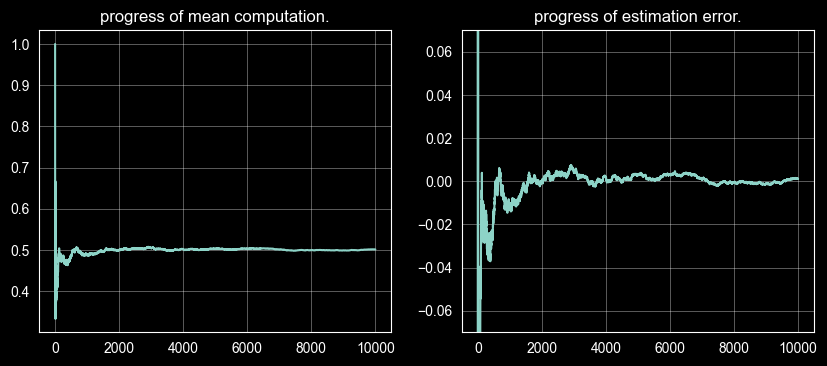

In [12]:
csum = torch.cumsum(X, dim=0)
p_est = torch.tensor([ cs / (k+1) for k, cs in enumerate(csum)])
# plot
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(range(n_samples), p_est); axes[0].set_title(f'progress of mean computation.')
axes[1].plot(range(n_samples), p_est - p); axes[1].set_title('progress of estimation error.')
axes[1].set_ylim(-0.07, 0.07); 

## Simulate 250 Bernoulli samples

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html

In [13]:
p = 0.5
ntotal = 250
nheads = 140

In [14]:
X = pyro.distributions.Bernoulli(p).sample(torch.Size([ntotal]))
print(f'{X.shape}, Heads: {X.sum()}')

torch.Size([250]), Heads: 142.0


In [15]:
with pyro.plate('plat', size=ntotal):
    X = pyro.sample('X', pyro.distributions.Bernoulli(p))
print(f'{X.shape}, Heads: {X.sum()}')

torch.Size([250]), Heads: 136.0


In [16]:
repeat = 100000
# slow, do not try
# heads_simul = [stats.bernoulli(p=p).rvs(ntotal).sum() for i in range(repeat)] 

In [17]:
with pyro.plate('repeat_plate', size=repeat):
    with pyro.plate('plat', size=ntotal):
        X = pyro.sample('X', pyro.distributions.Bernoulli(p))
print(f'{X.shape}, Heads: {X.sum()}')

torch.Size([250, 100000]), Heads: 12495361.0


In [18]:
X.sum(dim=0).shape, X.sum(dim=1).shape, X.sum(axis=1).shape  # dim or axis

(torch.Size([100000]), torch.Size([250]), torch.Size([250]))

The proportion that # of heads is over 140 is 3.374000072479248%


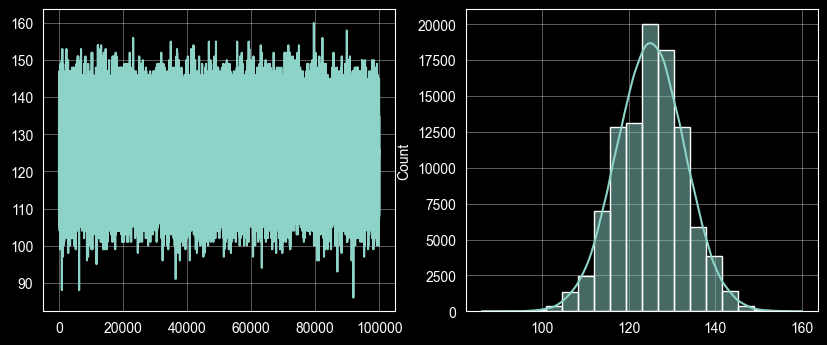

In [19]:
# repeat experiment
with pyro.plate('repeat_plate', size=repeat):
    # draw ntotal samples
    with pyro.plate('plat', size=ntotal):
        X = pyro.sample('X', pyro.distributions.Bernoulli(p))
#
heads_simul = X.sum(axis=0)
over_140 = heads_simul >= nheads
print(f'The proportion that # of heads is over 140 is {over_140.sum() * 100 / repeat}%')
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(heads_simul); 
sns.histplot(heads_simul, kde=True, bins=20);

## Simulate 250 Bernoulli samples, p=.55

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html

In [20]:
p = 0.55

The proportion that # of heads is over 140 is 39.875999450683594%


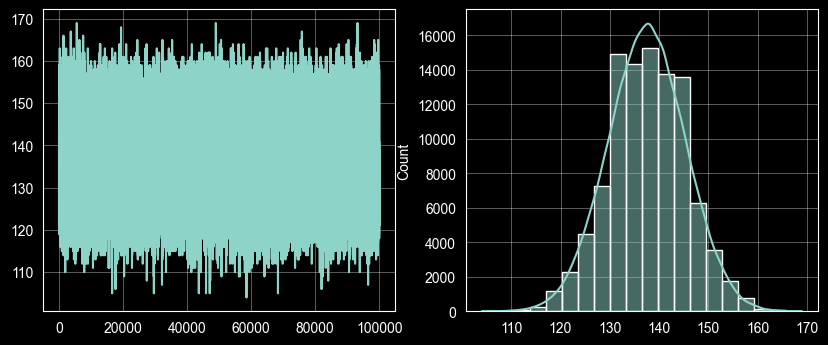

In [21]:
# repeat experiment
with pyro.plate('repeat_plate', size=repeat):
    # draw ntotal samples
    with pyro.plate('plat', size=ntotal):
        X = pyro.sample('X', pyro.distributions.Bernoulli(p))
#
heads_simul = X.sum(axis=0)
over_140 = heads_simul >= nheads
print(f'The proportion that # of heads is over 140 is {over_140.sum() * 100 / repeat}%')
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(heads_simul); 
sns.histplot(heads_simul, kde=True, bins=20);

## Estimation of p with uniform prior

In [22]:
probs = torch.linspace(.49, .60, 12);
probs

tensor([0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400, 0.5500, 0.5600, 0.5700,
        0.5800, 0.5900, 0.6000])

In [23]:
prior = torch.ones_like(probs) / len(probs)
log_prior = torch.log(prior)
print(f'candidate p: {probs}\nprior probability: {prior}')
print('log_prior: ', log_prior)

candidate p: tensor([0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400, 0.5500, 0.5600, 0.5700,
        0.5800, 0.5900, 0.6000])
prior probability: tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
        0.0833, 0.0833, 0.0833])
log_prior:  tensor([-2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849, -2.4849,
        -2.4849, -2.4849, -2.4849, -2.4849])


In [24]:
# for each hypothesis p, we comput
likelihood = torch.tensor([p**140 * (1-p)**110 for p in probs])
likelihood, likelihood.dtype

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), torch.float32)

In [25]:
# for each hypothesis p, we comput
likelihood = torch.tensor([torch.pow(p,140) * torch.pow(1-p,110) for p in probs])
likelihood, likelihood.dtype

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), torch.float32)

In [26]:
# for each hypothesis p, we comput
likelihood = torch.tensor([torch.log(torch.pow(p,140) * torch.pow(1-p,110)) for p in probs])
likelihood, likelihood.dtype

(tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]),
 torch.float32)

In [27]:
# for each hypothesis p, we comput
log_likelihood = torch.tensor([   torch.log(torch.pow(p,140)) 
                                + torch.log(torch.pow(1-p,110))
                              for p in probs])
log_likelihood

tensor([-173.9456, -173.2868, -172.7367, -172.2863, -171.9354, -171.6842,
        -171.5330, -171.4825, -171.5334, -171.6867, -171.9435, -172.3096])

In [28]:
# for each hypothesis p, we comput
log_likelihood = torch.tensor([   140*torch.log(p) 
                                + 110*torch.log(1-p)
                              for p in probs])
log_likelihood

tensor([-173.9369, -173.2868, -172.7367, -172.2863, -171.9354, -171.6842,
        -171.5330, -171.4825, -171.5334, -171.6869, -171.9444, -172.3076])

In [29]:
likelihood_scaled = torch.exp(log_likelihood - log_likelihood.min())
likelihood_scaled

tensor([ 1.0000,  1.9157,  3.3207,  5.2100,  7.3998,  9.5130, 11.0659, 11.6399,
        11.0622,  9.4880,  7.3339,  5.1005])

In [30]:
log_posterior_unnormalized = log_prior + log_likelihood
print('log_posterior_un:', log_posterior_unnormalized)
posterior_unnormalized = torch.exp(log_posterior_unnormalized)
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior

log_posterior_un: tensor([-176.4218, -175.7717, -175.2216, -174.7712, -174.4203, -174.1691,
        -174.0179, -173.9674, -174.0183, -174.1718, -174.4293, -174.7925])


tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [31]:
log_posterior_unnormalized = log_prior + log_likelihood
print('log_posterior_un:', log_posterior_unnormalized)
posterior_unnormalized = torch.exp(log_posterior_unnormalized - log_posterior_unnormalized.min())
# normalize to turn it into a pmf
posterior = posterior_unnormalized / posterior_unnormalized.sum()
print('posterior: ', posterior)
print('sum of posterior: ', posterior.sum())

log_posterior_un: tensor([-176.4218, -175.7717, -175.2216, -174.7712, -174.4203, -174.1691,
        -174.0179, -173.9674, -174.0183, -174.1718, -174.4293, -174.7925])
posterior:  tensor([0.0119, 0.0228, 0.0395, 0.0620, 0.0880, 0.1132, 0.1317, 0.1385, 0.1316,
        0.1129, 0.0873, 0.0607])
sum of posterior:  tensor(1.)


In [32]:
istar = torch.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5600000023841858


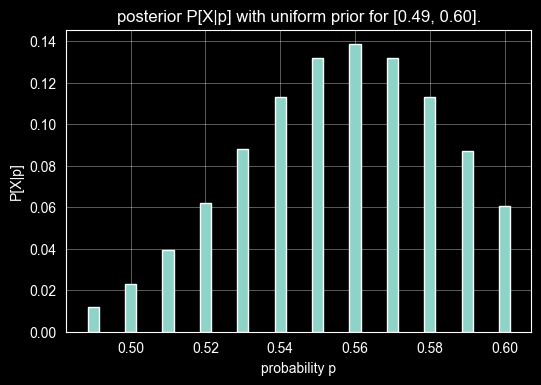

In [33]:
plt.bar(probs, posterior, width=.003)
plt.xlabel('probability p')
plt.ylabel('P[X|p]')
plt.title(f'posterior P[X|p] with uniform prior for [{probs.min():.2f}, {probs.max():.2f}].');

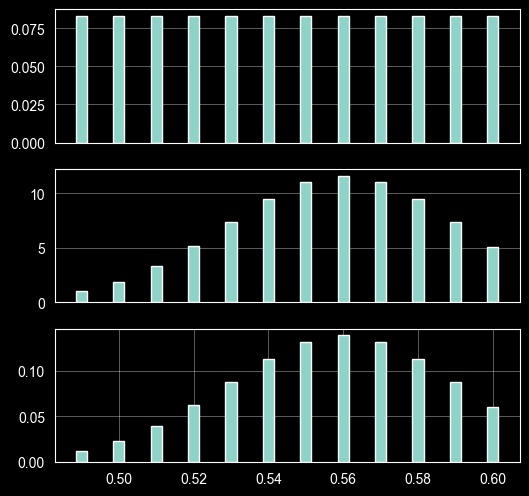

In [34]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood_scaled, posterior]):
    ax.bar(probs, pdf, width=.003)
axes[0].set_xticks([]); axes[1].set_xticks([]); 

## Estimation of p with triangular prior

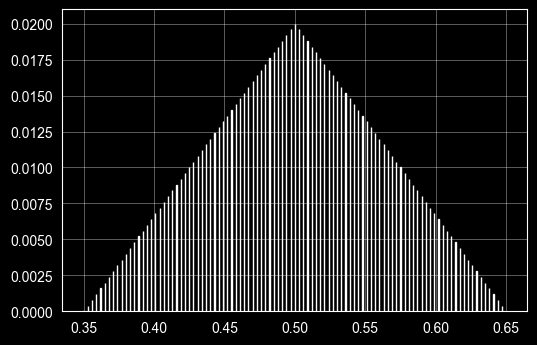

In [35]:
probs = torch.linspace(.35, .65, 101)
#
m = len(probs)//2
pm = probs[m]
prior = torch.empty_like(probs)
prior[:m] = torch.tensor([(1 - 0)/(probs[m] - probs[0])*(p - probs[0]) for p in probs[:m]])
prior[m:] = torch.tensor([(0 - 1)/(probs[-1] - probs[m])*(p - probs[m]) + 1 for p in probs[m:]])
prior = prior / prior.sum()
log_prior = torch.log(prior)
plt.bar(probs, prior, width=.0001);

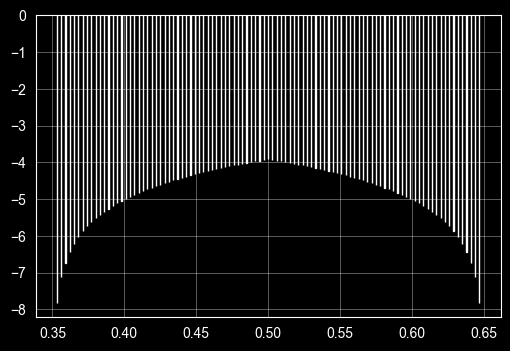

In [36]:
plt.bar(probs, log_prior, width=.0001);

<BarContainer object of 101 artists>

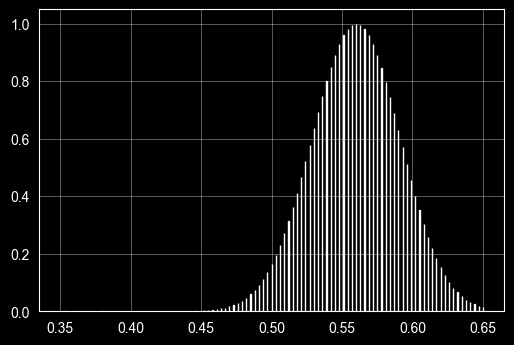

In [37]:
# for each hypothesis p, we comput
log_likelihood = torch.tensor([ 140*torch.log(p) + 110*torch.log(1-p) for p in probs])
log_likelihood = log_likelihood - log_likelihood.max()
likelihood = torch.exp(log_likelihood)
plt.bar(probs, likelihood, width=.0001)

In [38]:
posterior_unnormalized = prior * likelihood
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior

tensor([0.0000e+00, 2.9389e-13, 1.1528e-12, 3.3496e-12, 8.5467e-12, 2.0199e-11,
        4.5288e-11, 9.7561e-11, 2.0349e-10, 4.1303e-10, 8.1857e-10, 1.5880e-09,
        3.0212e-09, 5.6453e-09, 1.0371e-08, 1.8752e-08, 3.3391e-08, 5.8597e-08,
        1.0139e-07, 1.7308e-07, 2.9158e-07, 4.8492e-07, 7.9646e-07, 1.2922e-06,
        2.0715e-06, 3.2819e-06, 5.1396e-06, 7.9578e-06, 1.2184e-05, 1.8449e-05,
        2.7634e-05, 4.0947e-05, 6.0030e-05, 8.7084e-05, 1.2502e-04, 1.7764e-04,
        2.4983e-04, 3.4782e-04, 4.7939e-04, 6.5415e-04, 8.8384e-04, 1.1824e-03,
        1.5665e-03, 2.0552e-03, 2.6703e-03, 3.4365e-03, 4.3802e-03, 5.5300e-03,
        6.9157e-03, 8.5671e-03, 1.0513e-02, 1.2279e-02, 1.4208e-02, 1.6286e-02,
        1.8493e-02, 2.0801e-02, 2.3177e-02, 2.5581e-02, 2.7968e-02, 3.0287e-02,
        3.2487e-02, 3.4514e-02, 3.6316e-02, 3.7843e-02, 3.9054e-02, 3.9911e-02,
        4.0388e-02, 4.0467e-02, 4.0144e-02, 3.9425e-02, 3.8327e-02, 3.6881e-02,
        3.5123e-02, 3.3101e-02, 3.0867e-

In [39]:
log_posterior_unnormalized = log_prior + log_likelihood
log_posterior_unnormalized = log_posterior_unnormalized - log_posterior_unnormalized.max()
posterior_unnormalized = torch.exp(log_posterior_unnormalized)
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior

tensor([0.0000e+00, 2.9389e-13, 1.1528e-12, 3.3496e-12, 8.5467e-12, 2.0199e-11,
        4.5288e-11, 9.7561e-11, 2.0349e-10, 4.1303e-10, 8.1856e-10, 1.5880e-09,
        3.0212e-09, 5.6453e-09, 1.0371e-08, 1.8752e-08, 3.3391e-08, 5.8597e-08,
        1.0139e-07, 1.7308e-07, 2.9158e-07, 4.8492e-07, 7.9646e-07, 1.2922e-06,
        2.0715e-06, 3.2819e-06, 5.1396e-06, 7.9578e-06, 1.2184e-05, 1.8449e-05,
        2.7634e-05, 4.0947e-05, 6.0030e-05, 8.7084e-05, 1.2502e-04, 1.7764e-04,
        2.4983e-04, 3.4782e-04, 4.7939e-04, 6.5415e-04, 8.8384e-04, 1.1824e-03,
        1.5665e-03, 2.0552e-03, 2.6703e-03, 3.4365e-03, 4.3802e-03, 5.5300e-03,
        6.9157e-03, 8.5671e-03, 1.0513e-02, 1.2279e-02, 1.4208e-02, 1.6286e-02,
        1.8493e-02, 2.0801e-02, 2.3177e-02, 2.5581e-02, 2.7968e-02, 3.0287e-02,
        3.2487e-02, 3.4514e-02, 3.6316e-02, 3.7843e-02, 3.9054e-02, 3.9911e-02,
        4.0388e-02, 4.0467e-02, 4.0144e-02, 3.9425e-02, 3.8327e-02, 3.6881e-02,
        3.5123e-02, 3.3101e-02, 3.0867e-

In [40]:
istar = torch.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5509999990463257


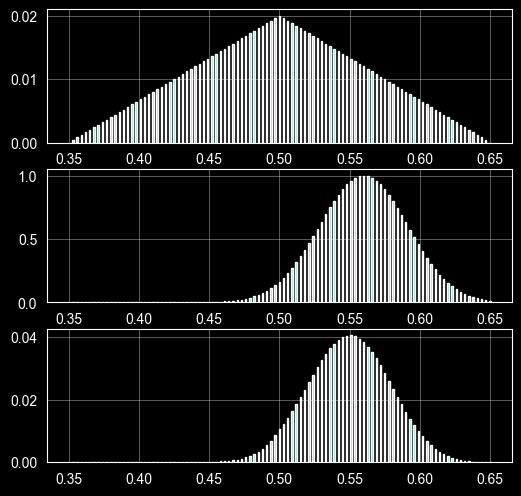

In [41]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood, posterior]):
    ax.bar(probs, pdf, width=.001)

## Estimation of p with Grids from Beta($\alpha$, $\beta$)

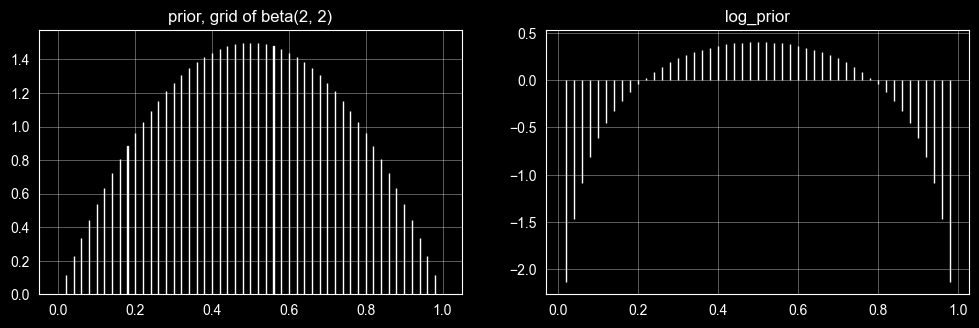

In [42]:
probs = torch.linspace(.0, 1., 51)
#
alpha, beta = 2, 2
log_prior = pyro.distributions.Beta(alpha, beta).log_prob(probs)  # density values are sampled
prior = torch.exp(log_prior)
# prior /= prior.sum()  # not necessary. normalization can be done at the last step

# plot
fig, axes = plt.subplots(1, 2, figsize=(12,3.5))
width = 0.0001
axes[0].bar(probs, prior, width=width); axes[0].set(title=f'prior, grid of beta({alpha}, {beta})')
axes[1].bar(probs, log_prior, width=width); axes[1].set(title='log_prior');

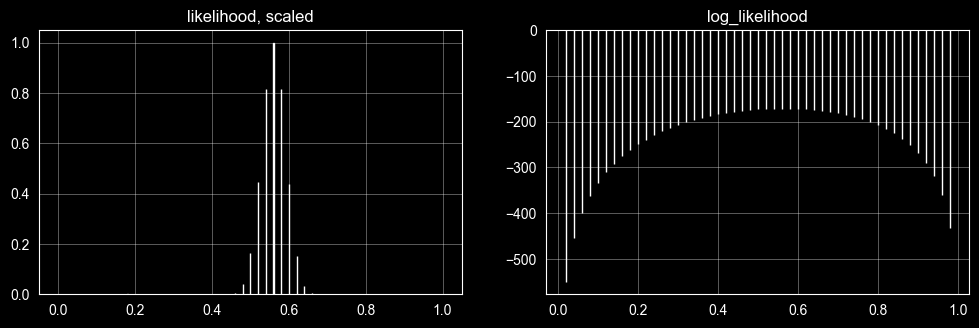

In [43]:
# for each hypothesis p, we compute
log_likelihood = torch.tensor([ 140*torch.log(p) + 110*torch.log(1-p) for p in probs ])
likelihood = torch.exp(log_likelihood - log_likelihood.max())
#
fig, axes = plt.subplots(1, 2, figsize=(12,3.5))
width = 0.0001
axes[0].bar(probs, likelihood, width=width); axes[0].set(title=f'likelihood, scaled')
axes[1].bar(probs, log_likelihood, width=width); axes[1].set(title='log_likelihood');

In [44]:
log_posterior = log_prior + log_likelihood
print(log_posterior[:4])
posterior_unnormalized = torch.exp(log_posterior - log_posterior.max())
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior[:10]

tensor([     -inf, -552.0460, -456.6010, -401.7673])


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2605e-41])

**Caution**

Because Beta(a,b) is not defined at x=0 and x=1, we must avoid these points when we evaluate `log` function.

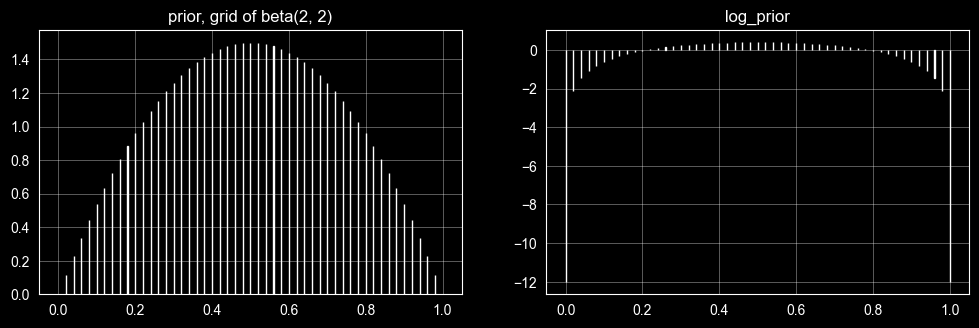

In [45]:
eps = 0.000001
probs = torch.linspace(.0+eps, 1.-eps, 51)
#
alpha, beta = 2, 2
log_prior = pyro.distributions.Beta(alpha, beta).log_prob(probs)  # density values are sampled
prior = torch.exp(log_prior)
# prior /= prior.sum()  # not necessary. normalization can be done at the last step

# plot
fig, axes = plt.subplots(1, 2, figsize=(12,3.5))
width = 0.0001
axes[0].bar(probs, prior, width=width); axes[0].set(title=f'prior, grid of beta({alpha}, {beta})')
axes[1].bar(probs, log_prior, width=width); axes[1].set(title='log_prior');

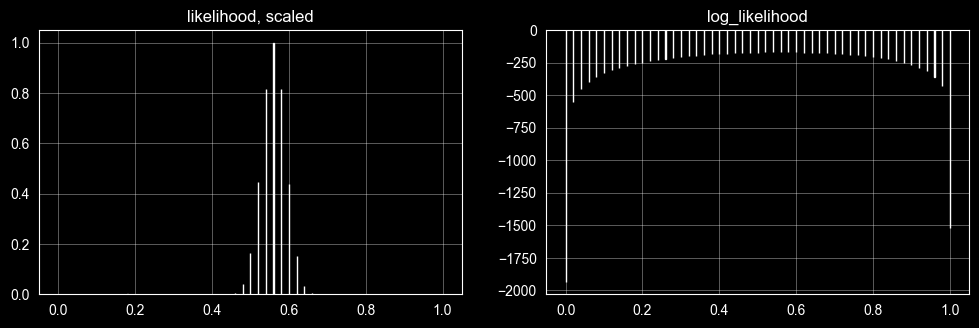

In [46]:
# for each hypothesis p, we compute
log_likelihood = torch.tensor([ 140*torch.log(p) + 110*torch.log(1-p) for p in probs ])
likelihood = torch.exp(log_likelihood - log_likelihood.max())
#
fig, axes = plt.subplots(1, 2, figsize=(12,3.5))
width = 0.0001
axes[0].bar(probs, likelihood, width=width); axes[0].set(title=f'likelihood, scaled')
axes[1].bar(probs, log_likelihood, width=width); axes[1].set(title='log_likelihood');

In [47]:
log_posterior = log_prior + log_likelihood
print(log_posterior[:4])
posterior_unnormalized = torch.exp(log_posterior - log_posterior.max())
posterior = posterior_unnormalized / posterior_unnormalized.sum()
posterior[:3], posterior[-3:]

tensor([-1946.1954,  -552.0394,  -456.5979,  -401.7654])


(tensor([0., 0., 0.]), tensor([0., 0., 0.]))

In [48]:
istar = torch.argmax(posterior)
pstar = probs[istar]
print(f'* best estimate is {pstar}')

* best estimate is 0.5599998235702515


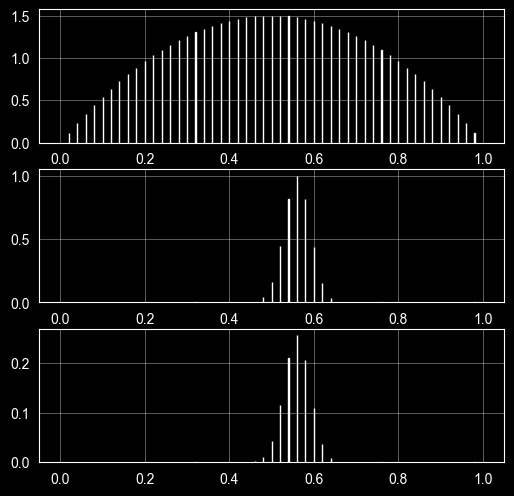

In [49]:
fig, axes = plt.subplots(3,1, figsize=(6,6))
for ax, pdf in zip(axes, [prior, likelihood, posterior]):
    ax.bar(probs, pdf, width=width)

- Not much can be seen from the graphs of this experiment and the posterior distribution looks almost the same as the likelihood.
- This is because the prior distribution is very much wide. It acts like a uniform distribution.

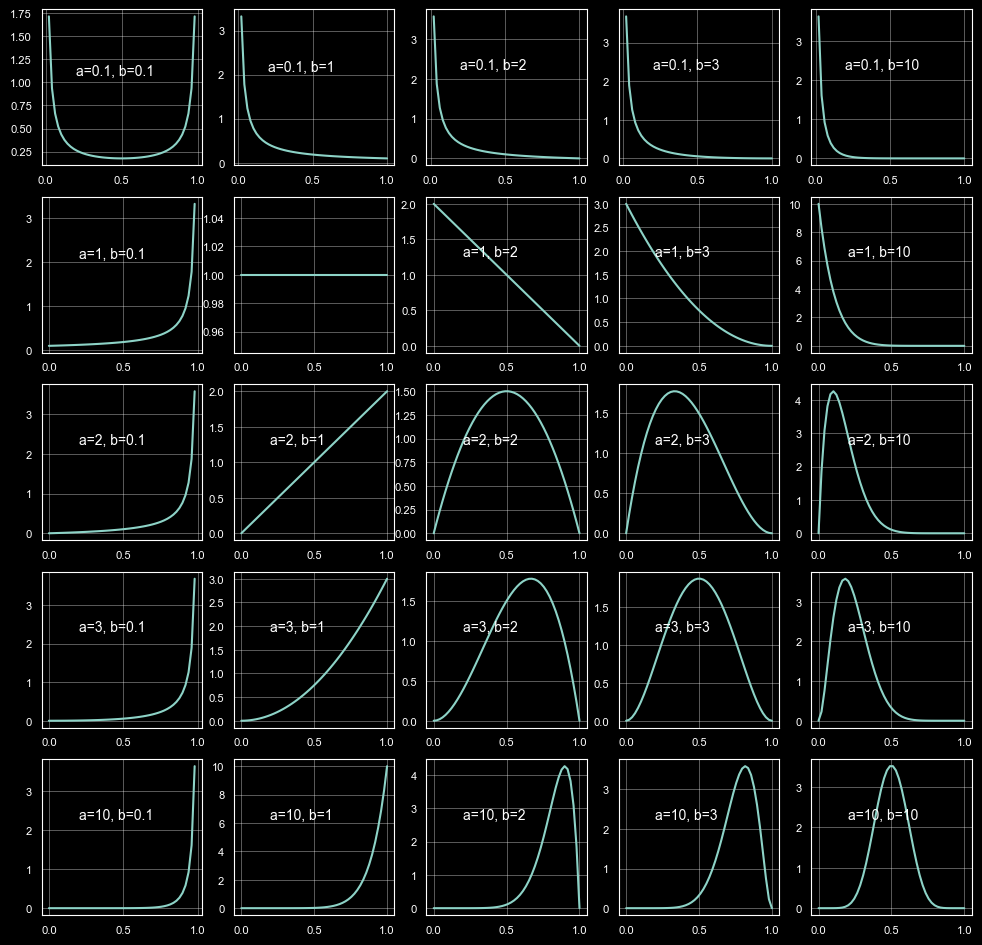

In [50]:
import scipy.stats as stats  # more convenient for the plotting

## Beta distributions
alphas = [0.1, 1, 2, 3, 10]
betas = [0.1, 1, 2, 3, 10]
p = np.linspace(0, 1, 50)
fig, axes = plt.subplots(5, 5, figsize=(12,12))
for i, a in enumerate(alphas):
    for j, b in enumerate(betas):
        ax = axes[i,j]
        ax.plot(p, stats.beta(a,b).pdf(p))
        ax.tick_params(labelsize=8)
        ax.text(0.2, ax.get_ylim()[1]*.6, f'a={a}, b={b}')